# 0.3.3 La curva ROC (Receiver operating characteristic)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append("../../../../") 

import utils.paths as path
from utils.paths2 import direcciones

## 0.3.1.1 Definición

Es una matriz que permite visualizar el desempeño de un clasificador. La organización típica es la presentada a continuación:

In [4]:
#
# Cálculo a partir de los valores reales y los pronósticos
#

y_true = [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
y_pred = [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


confusion_matrix(
    # -------------------------------------------------------------------------
    # Ground truth (correct) target values.
    y_true=y_true,
    # -------------------------------------------------------------------------
    # Estimated targets as returned by a classifier.
    y_pred=y_pred,
    # -------------------------------------------------------------------------
    # List of labels to index the matrix.
    labels=None,
    # -------------------------------------------------------------------------
    # Normalizes confusion matrix over the true (rows), predicted (columns)
    # conditions or all the population.
    # 'true', 'pred', 'all'
    normalize=None,
)

array([[10,  1],
       [ 3,  1]], dtype=int64)

In [5]:
confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    labels=[1, 0],
    normalize=None,
)

array([[ 1,  3],
       [ 1, 10]], dtype=int64)

In [6]:
pd.DataFrame(
    confusion_matrix(
        y_true=y_true,
        y_pred=y_pred,
        labels=[1, 0],
        normalize=None,
    ),
    columns=["PP", "PF"],
    index=["P", "F"],
)

#
#          | Pronóstico
#          |  PP    PN
# ---------|------------
#       P  |  TP    FN
# Real     |
#       N  |  FP    TN
#

,PP,PF
P,1,3
F,1,10


In [7]:
#
# Extracción de los elementos de la matriz de confusión
#
tn, fp, fn, tp = confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
).ravel()

display(
    tn,
    fp,
    fn,
    tp,
)

10

1

3

1

## 0.3.1.2 Matriz de confusión para más de dos clases

In [8]:
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=0,
)

clf = SVC(kernel="linear", C=0.01).fit(X_train, y_train)

y_pred = clf.predict(X_train)

cm = confusion_matrix(
    y_true=y_train,
    y_pred=y_pred,
    labels=None,
    normalize=None,
)

cm

array([[37,  0,  0],
       [ 0, 24, 10],
       [ 0,  1, 40]], dtype=int64)

## 0.3.1.3 Visualización de la matriz de confusión

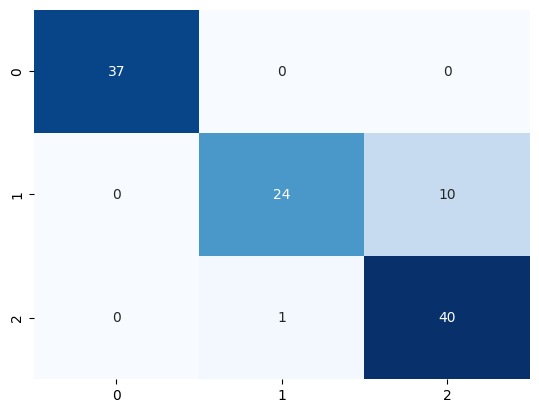

In [9]:
sns.heatmap(
    cm,
    cbar=False,
    cmap="Blues",
    annot=True,
    fmt="d",
)
plt.show()

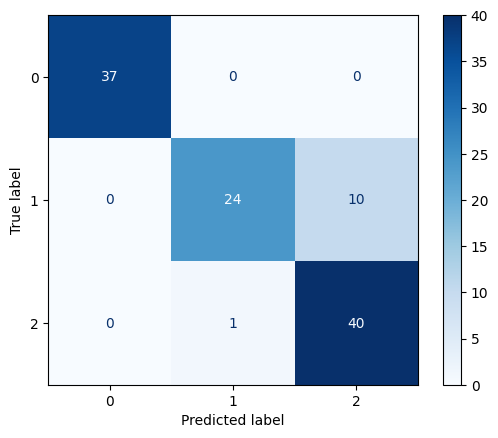

In [10]:
confusionMatrixDisplay = ConfusionMatrixDisplay(
    # -------------------------------------------------------------------------
    # Confusion matrix.
    confusion_matrix=cm,
    # -------------------------------------------------------------------------
    # Display labels for plot. If None, display labels are set from 0 to
    # n_classes - 1.
    display_labels=clf.classes_,
)

confusionMatrixDisplay.plot(cmap="Blues")
plt.show()

## 0.3.1.4 Normalización

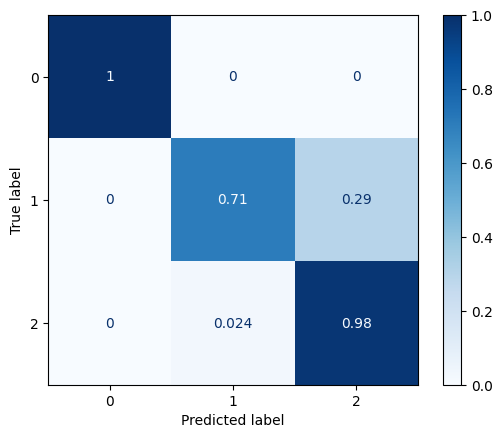

In [11]:
#
# Normalización sobre las filas (true)
#
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train,
        y_pred=y_pred,
        normalize="true",
    ),
    display_labels=clf.classes_,
).plot(cmap="Blues")
plt.show()

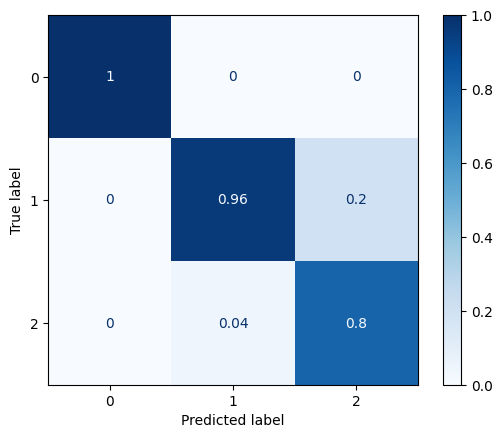

In [12]:
#
# Normalización sobre las columnas (pred)
#
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train,
        y_pred=y_pred,
        normalize="pred",
    ),
    display_labels=clf.classes_,
).plot(cmap="Blues")
plt.show()

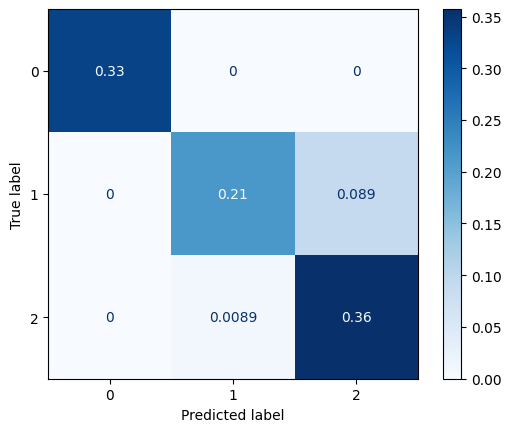

In [13]:
#
# Normalización sobre todos los datos
#
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_true=y_train,
        y_pred=y_pred,
        normalize="all",
    ),
    display_labels=clf.classes_,
).plot(cmap="Blues")
plt.show()

In [14]:
print('ok_')

ok_
